In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

Train images shape:  (10000, 96, 96, 3)
Train labels shape:  (10000, 12, 12)
Weights shape: (10000, 12, 12)


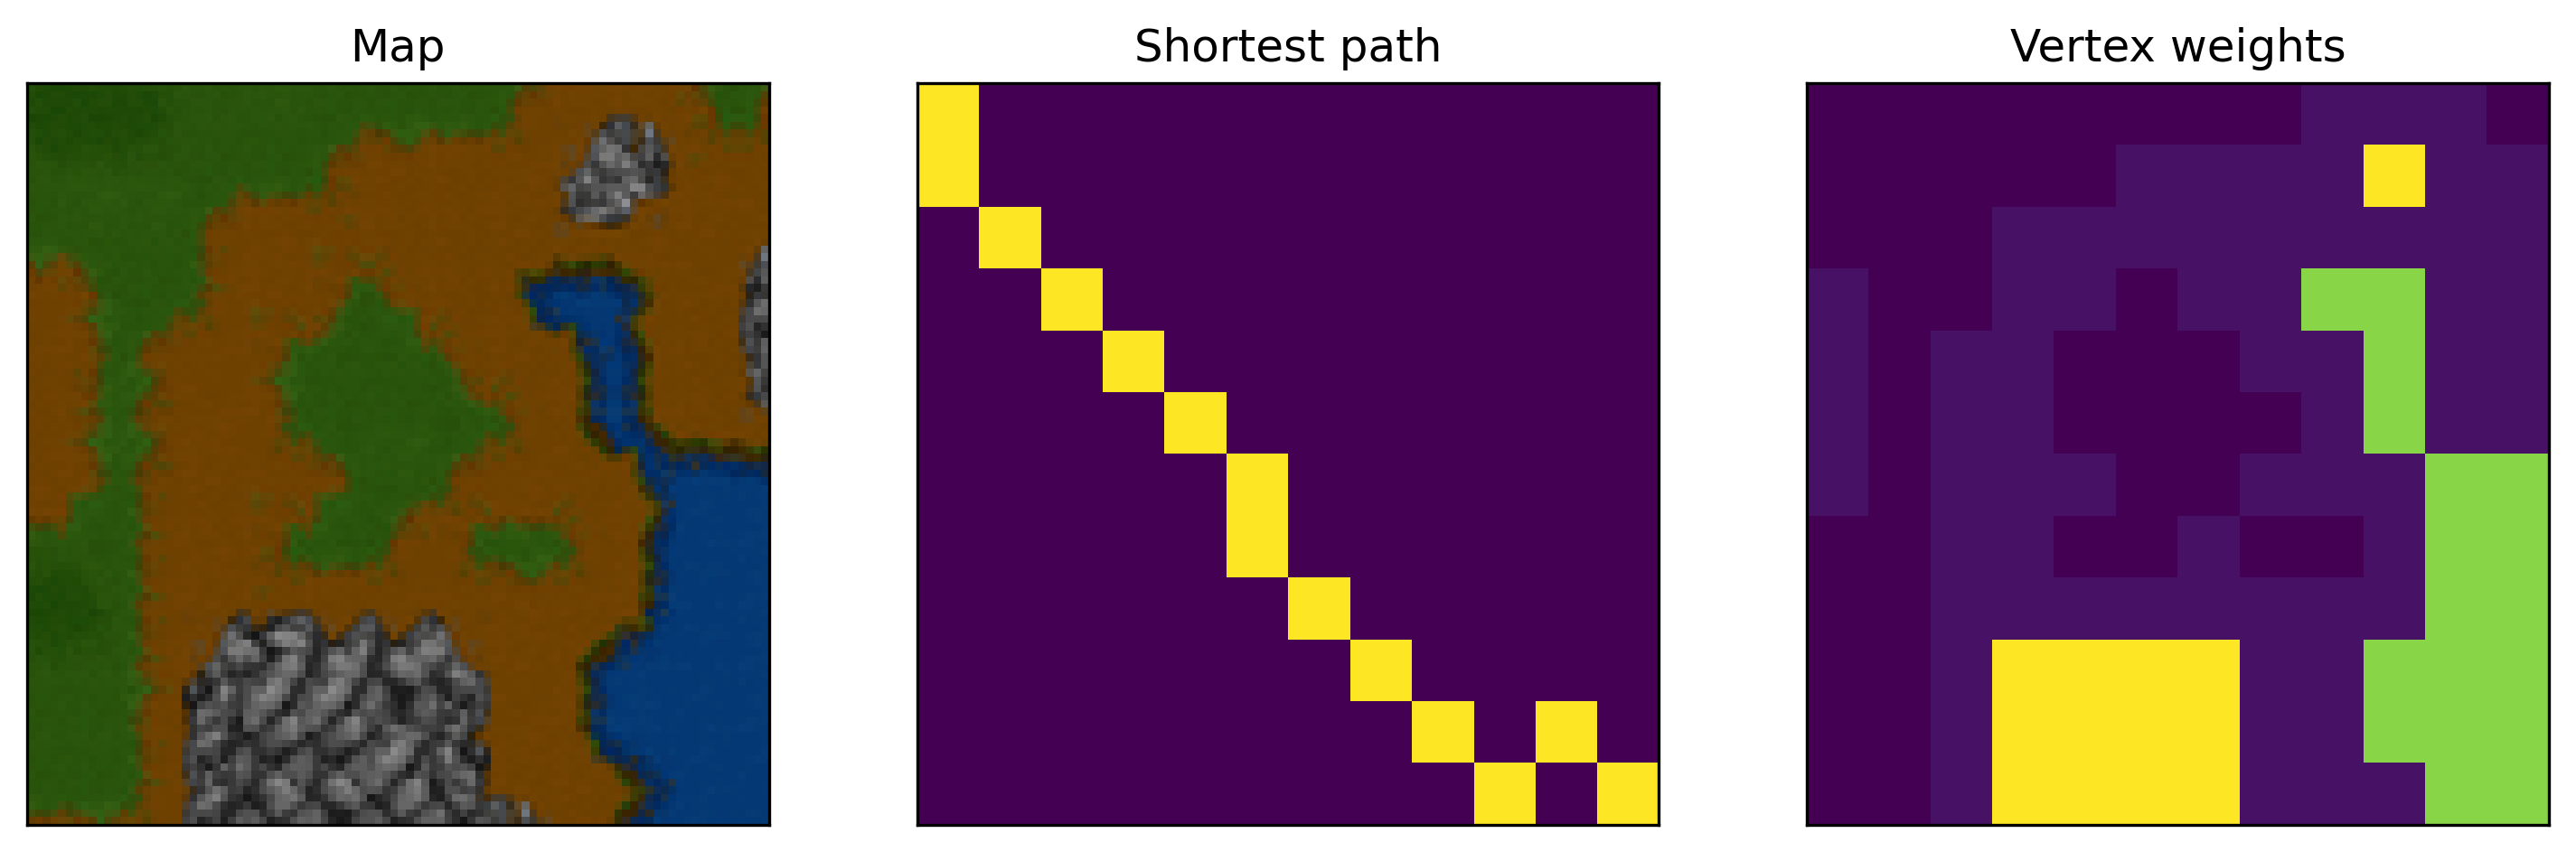

In [38]:
data_dir = "/workspaces/masters_project/data/warcraft_shortest_path_oneskin/12x12/"
data_suffix = "maps"
train_prefix = "train"


train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy"))
train_weights = np.load(os.path.join(data_dir, train_prefix + "_vertex_weights.npy"))
train_labels = np.load(os.path.join(data_dir, train_prefix + "_shortest_paths.npy"))

#images = train_inputs.transpose(0,2,3,1).astype(np.uint8)
images = train_inputs

print("Train images shape: ", train_inputs.shape)
print("Train labels shape: ",  train_labels.shape)
print("Weights shape:", train_weights.shape)

idx = 0
im = images[idx]
label = train_labels[idx]
weights = train_weights[idx]


fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=300)

ax[0].imshow(im.astype(np.uint8))
ax[0].set_title("Map")
ax[1].imshow(label)
ax[1].set_title("Shortest path")
ax[2].set_title("Vertex weights")
ax[2].imshow(weights.astype(np.float32))

ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xticks([])
plt.savefig("example.png", dpi=300)

In [4]:
im.shape

(96, 96, 3)

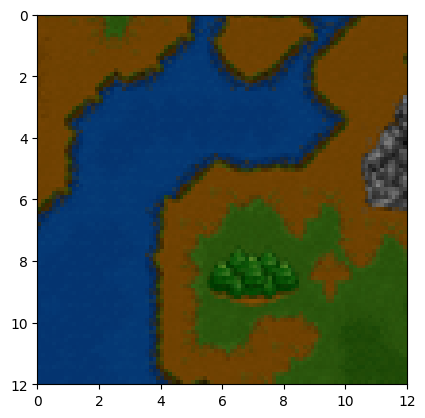

In [3]:
#plt image with the x, y axis ticks 
plt.imshow(im.astype(np.uint8), extent=(0, 12, 12, 0), origin="upper")
#convert the image scaling in the y axis to 0 -> 96 from bottom to top


(array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6]), array([0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5,
       6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3,
       4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7]), array([ 8,  9, 10, 11, 12, 13, 14, 15, 16,  8,  9, 10, 11, 12, 13, 14, 15,
       16,  8,  9, 10, 11, 12, 13, 14, 15,  8,  9, 10, 11, 12, 13, 14, 15,
       16,  8,  9, 10, 11, 12, 13, 14, 15, 16,  8,  9, 10, 11, 12, 13, 14,
       15, 16,  9, 10, 11, 12, 13, 14, 15, 16, 13, 14, 16]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4

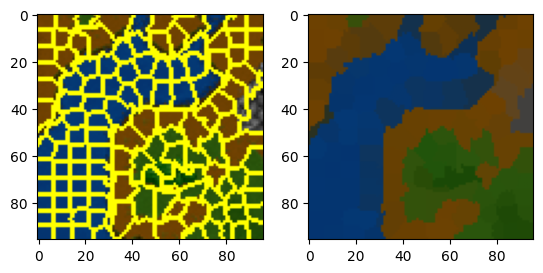

/home/codespace/.python/current/lib/python3.10/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)


In [5]:

import numpy as np
from torch_geometric.data import Data
from torch_geometric.transforms import ToSLIC
import torch
#torch transform bilinear interpolation
#torch transform resize
from torch.nn.functional import interpolate
from skimage.segmentation import slic
from skimage import graph as sk_graph
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.measure import regionprops
import networkx as nx
import torch_geometric as pyg
import skimage as sk
image = im
def path_to_graph(centroids, label, sensitivity=0.25,
                  resize_shape=(96, 96)):
    """"""
    label = sk.transform.resize(label, resize_shape)
    centroid_is_path = np.zeros(len(centroids)) # One-hot encoding if a centroid is part of the path or not
    centroid = centroids.numpy()

    for row in range(len(label)):
        for column in range(len(label)):
            if label[column, row] > np.max(label) - (sensitivity*np.max(label)): # Choose the 30% brightest spots on the label only
                dists = [np.linalg.norm([row, column] - c) for c in centroid] 

                centroid_is_path[np.argmin(dists)] = 1
    
    return torch.tensor(centroid_is_path)

def convert_image_to_graph(image, num_segments, label, compactness=10, sigma=0.0):
    """
    We have an image of size 12x12. We want to convert this into a graph
    where the nodes are the pixels. The edges are the pixels that are adjacent
    to each other. 
    
    The attribute of each node is a 3 dimensional vector,
    which is the RGB value of the pixel.
    """
    #first we need to create the nodes
    #the nodes are the pixels in the image
    segments = slic(image, n_segments=num_segments, compactness=compactness,
                     sigma=sigma,
                    enforce_connectivity=True)
    #this actually means that the centroids 
    new_image = np.zeros((96, 96, 3))

    unique_segments = np.unique(segments)
    for segment in unique_segments:
        indices = np.where(segments == segment)
        average_colour = np.mean(image[indices], axis=0)
        new_image[indices] = average_colour
        print(indices)
    new_image = new_image / 255

    boundaries_test = find_boundaries(segments)
    boundaries = mark_boundaries(image, segments)

    #plot boundaries and new image side by side
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(boundaries)
    axs[1].imshow(new_image)
    plt.show()
    rag = sk_graph.rag_mean_color(new_image, segments)
    regions = regionprops(segments)

    for region in regions:
        #currently we get (y, x ), changing to be (x, y)
#        coords = region['centroid']

 #       region['centroid'] = (coords[1], coords[0])
  #      print(region["centroid"])
        rag.nodes[region['label']]['centroid'] = region['centroid']
    graph = nx.Graph(rag)

    #graph = nx.Graph(graph_two)
    #convert graph_three to pytorch geometric
    #convert the graph to a torch geometric data object
    data = pyg.utils.from_networkx(graph)
    data.pixel_count = data["pixel count"]
    data.mean_color = data["mean color"]
    data.total_color = data["total color"] 
    data.edge_attr = data.weight
    data.labels = data.labels - 1.0
    #We can flip this here if we want
    data.centroid = data.centroid[:, [0, 1]]
   
    #change the 0th and 1th component of data['centroid]
    #data.centroid = [data.centroid[:1], data.centroid[:0]]
    centroid_is_path = path_to_graph(data["centroid"], label)
    data["centroid_in_path"] = centroid_is_path
    region_bc = boundaries
    return data, region_bc
    
data, bc = convert_image_to_graph(image, 200, label=label, compactness=10, sigma=0.0)

In [6]:
data.centroid[:10]

tensor([[ 3.0000,  3.5000],
        [ 3.1562, 12.1094],
        [ 2.2500, 20.0909],
        [ 4.0758, 32.4470],
        [ 4.6047, 43.5930],
        [ 3.0375, 53.4375],
        [ 4.9558, 65.3097],
        [ 4.0116, 75.3837],
        [ 3.3036, 84.3393],
        [ 3.0000, 92.0000]], dtype=torch.float64)

In [7]:
previous = data.centroid
previous[:10]


tensor([[ 3.0000,  3.5000],
        [ 3.1562, 12.1094],
        [ 2.2500, 20.0909],
        [ 4.0758, 32.4470],
        [ 4.6047, 43.5930],
        [ 3.0375, 53.4375],
        [ 4.9558, 65.3097],
        [ 4.0116, 75.3837],
        [ 3.3036, 84.3393],
        [ 3.0000, 92.0000]], dtype=torch.float64)

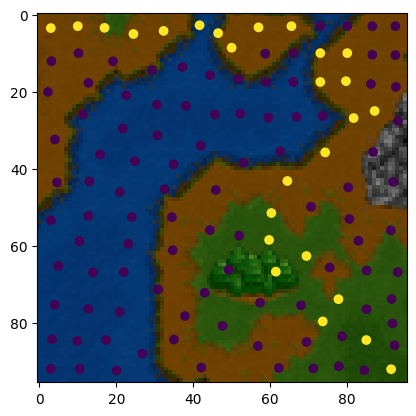

In [8]:
#generate a scatter plot of data.centroid
centroid = data.centroid.numpy()
centroid_in_path = data.centroid_in_path.numpy()
plt.imshow(im)

plt.scatter(centroid[:, 0], centroid[:, 1], c=centroid_in_path)
#change the way its plotted to have 0, 0 at the top left 
#instead of bottom left
#plot the vertex weights


In [9]:
centroid.max(axis=0), centroid.min(axis=0)

(array([93.15789474, 92.43243243]), array([2.25      , 2.76388889]))

In [10]:
centroid = centroid / 95 #forces it between 0 and 95. which is the actual size of the image.
centroid = centroid * 11 #forces it to be between 0 and 11


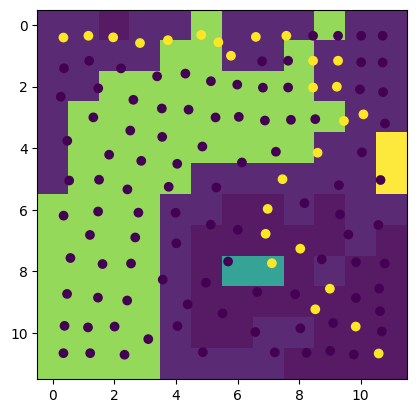

In [11]:
#PLot the vertex weights and the labels
plt.imshow(weights, alpha=0.9)#, extent=([0, 11, 11,0]))
#resize the coordinates to lie between 0 and 1
#plot an vertical line at x = 12, y = 12
#plt.hlines(12, 0, 13, colors="r")
#plt.vlines(12, 0, 13, colors="r")
#put a xlim and ylim to 0, 0 to be the lower limit

plt.scatter(centroid[:, 0], centroid[:, 1], c=centroid_in_path, 
             )


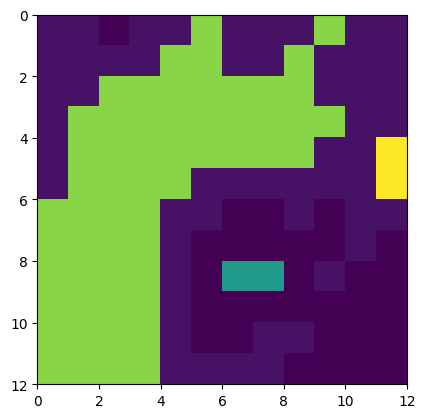

In [12]:
plt.imshow(weights, extent=([0, 12, 12,0]))


In [13]:
#calculate the min and max of the x and y coordinates
x_min = np.min(centroid[:, 0])
x_max = np.max(centroid[:, 0])
y_min = np.min(centroid[:, 1])
y_max = np.max(centroid[:, 1])
print(x_min, x_max, y_min, y_max)

0.2605263157894737 10.786703601108034 0.3200292397660819 10.702702702702704


In [14]:
def bilinear_interpolation(image, nodes):
    values = []
    height, width = image.shape
    
    for node in nodes:
        x, y = node
        
        i, j = int(x), int(y)
        alpha, beta = x - i, y - j
        
        if i < 0 or i >= height - 1 or j < 0 or j >= width - 1:
            values.append(np.nan)  # Node outside the image bounds
        else:
            interpolated_value = (1 - alpha) * (1 - beta) * image[i, j] + \
                                 alpha * (1 - beta) * image[i + 1, j] + \
                                 (1 - alpha) * beta * image[i, j + 1] + \
                                 alpha * beta * image[i + 1, j + 1]
            values.append(interpolated_value)
    
    return values
values = bilinear_interpolation(weights, centroid)
def path_to_graph_two(graph, weight_image):
    values = bilinear_interpolation(weight_image, graph.centroid)
    data.centroid_values = torch.tensor(values)
    distances = torch.norm(graph.centroid, dim=1)
    #find the index of the maximum distance
    target = torch.argmax(distances).item()
    x = data.centroid_values
    graph.x = x
    nx_graph = pyg.utils.to_networkx(graph)
    path = nx.shortest_path(nx_graph, source=0, target=target)

    # path is a set of integers, we want to create a tensor
    #where the path is 1 and the rest is 0 of size target
    #create a tensor of size target
    path_tensor = torch.zeros(data.centroid.shape[0])
    #set the path nodes to 1
    path_tensor[path] = 1
    path_tensor.unsqueeze(0)
    data.centroid_in_path = path_tensor
    return data

    

For each position extract the vertex weights associated with the cordinate.

In [15]:
values

[1.2001953125,
 1.098026621704947,
 1.0007320161011082,
 3.522030944918148,
 7.389779323171666,
 1.2001953125,
 3.2967297101300366,
 4.555196439361969,
 2.140842293471853,
 1.2001953125,
 3.2670739869120937,
 2.5543777939439956,
 1.3906509046052633,
 4.303307976973684,
 1.2001953125,
 2.1789254385965013,
 1.2001953125,
 1.2001953124999998,
 7.631790664804307,
 4.272840154645377,
 7.095156767844776,
 7.69921875,
 1.2001953125,
 4.674815949795777,
 1.2116867297276073,
 1.2001953125,
 4.125911098084338,
 7.699218749999999,
 7.69921875,
 7.69921875,
 7.69921875,
 7.69921875,
 7.69921875,
 7.699218749999999,
 4.356226511534158,
 1.3595756145565272,
 6.7169687955144015,
 7.69921875,
 7.69921875,
 7.69921875,
 7.69921875,
 1.2001953125,
 4.387332502902478,
 7.620240459189132,
 7.69921875,
 7.564116276484351,
 6.150614357585138,
 7.69921875,
 1.2001953124999998,
 7.69921875,
 7.69921875,
 3.2800728424250734,
 1.3120921171879398,
 5.912058048855885,
 1.1663306428085043,
 7.69921875,
 1.14799863

In [16]:
data

Data(edge_index=[2, 682], labels=[123, 1], pixel count=[123], total color=[123, 3], mean color=[123, 3], centroid=[123, 2], weight=[682], num_nodes=123, pixel_count=[123], mean_color=[123, 3], total_color=[123, 3], edge_attr=[682], centroid_in_path=[123])

In [17]:
data.centroid_values = torch.tensor(values)

In [18]:
target

NameError: name 'target' is not defined

In [28]:
graph.x

tensor([1.2002, 1.0980, 1.0007, 3.5220, 7.3898, 1.2002, 3.2967, 4.5552, 2.1408,
        1.2002, 3.2671, 2.5544, 1.3907, 4.3033, 1.2002, 2.1789, 1.2002, 1.2002,
        7.6318, 4.2728, 7.0952, 7.6992, 1.2002, 4.6748, 1.2117, 1.2002, 4.1259,
        7.6992, 7.6992, 7.6992, 7.6992, 7.6992, 7.6992, 7.6992, 4.3562, 1.3596,
        6.7170, 7.6992, 7.6992, 7.6992, 7.6992, 1.2002, 4.3873, 7.6202, 7.6992,
        7.5641, 6.1506, 7.6992, 1.2002, 7.6992, 7.6992, 3.2801, 1.3121, 5.9121,
        1.1663, 7.6992, 1.1480, 1.1102, 7.6992, 1.0693, 7.6934, 1.1739, 7.6992,
        0.7998, 7.6992, 0.8001, 0.8478, 1.1864, 7.6992, 7.6992, 7.6992, 0.7998,
        7.0565, 0.9381, 1.1554, 0.8076, 0.9176, 7.6992, 7.6992, 7.6992, 7.2069,
        1.0575, 4.0082, 3.7068, 0.8591, 1.1421, 0.7998, 0.9469, 7.6992, 7.6992,
        7.6992, 7.3500, 1.2705, 0.7998, 0.8003, 0.8191, 0.7998, 0.7998, 7.6992,
        7.6992, 7.6992, 6.9701, 0.9923, 1.1386, 1.1497, 0.8473, 0.7998, 0.7998,
        7.6992, 7.6992, 7.6992, 7.6992, 

In [31]:
graph.centroid

tensor([[ 3.0000,  3.5000],
        [ 3.1562, 12.1094],
        [ 2.2500, 20.0909],
        [ 4.0758, 32.4470],
        [ 4.6047, 43.5930],
        [ 3.0375, 53.4375],
        [ 4.9558, 65.3097],
        [ 4.0116, 75.3837],
        [ 3.3036, 84.3393],
        [ 3.0000, 92.0000],
        [11.3830, 25.8794],
        [10.4359, 58.8462],
        [10.2182, 10.0182],
        [12.7600, 17.7333],
        [10.0000,  3.0000],
        [12.6800, 76.4267],
        [ 9.8846, 84.7692],
        [10.5000, 92.0000],
        [12.9855, 43.3623],
        [12.7195, 52.2805],
        [13.9571, 67.0000],
        [15.8116, 36.3478],
        [16.9455,  3.4364],
        [19.1429, 12.1429],
        [17.3448, 84.5345],
        [20.1216, 92.4324],
        [20.8721, 77.2326],
        [21.7361, 29.5694],
        [20.9375, 46.0750],
        [21.9494, 66.8608],
        [23.1304, 59.5507],
        [22.6087, 20.9565],
        [24.0147, 52.5882],
        [24.8169, 38.0704],
        [24.4615,  5.0385],
        [26.7870, 88

In [29]:
graph = data
#find the target by finidng the node with the highest centroid in path (x, y) value (has to be maximum of both)
distances = torch.norm(data.centroid, dim=1)
#find the index of the maximum distance
target = torch.argmax(distances).item()
x = data.centroid_values
graph.x = x
nx_graph = pyg.utils.to_networkx(graph)
path = nx.shortest_path(nx_graph, source=0, target=target)

# path is a set of integers, we want to create a tensor
#where the path is 1 and the rest is 0 of size target
#create a tensor of size target
path_tensor = torch.zeros(data.centroid.shape[0])
#set the path nodes to 1
path_tensor[path] = 1
path_tensor.unsqueeze(0)


tensor([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
data_temp = data
data_temp.centroid_in_path = path_tensor


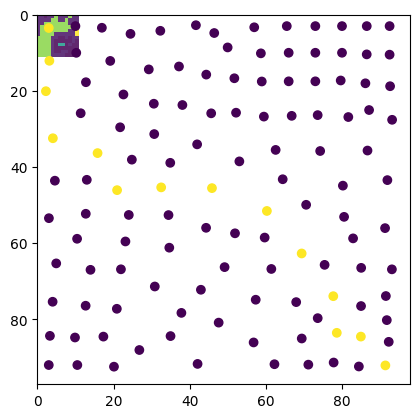

In [37]:
#plot the path
plt.imshow(weights, extent=([0, 11, 11,0]), alpha=0.85)
plt.scatter(data.centroid[:, 0], data.centroid[:, 1], 
             c=path_tensor.numpy(),)

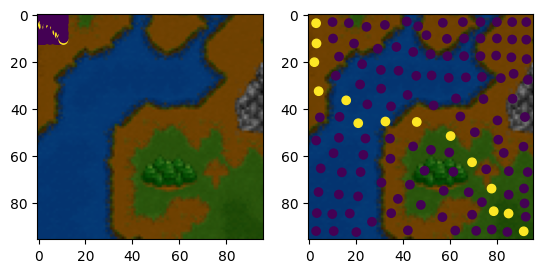

In [22]:
# plt.imshow(im, extent=([0, 11, 11,0]),)
# plt.scatter(centroid[:, 0], centroid[:, 1], 
#              c=path_tensor.numpy(),)
#plot the two path side by side
fig, axs = plt.subplots(1,2)
axs[0].imshow(im,)
axs[0].scatter(centroid[:, 0], centroid[:, 1], 
             c=path_tensor.numpy(),)
axs[1].imshow(im,)
axs[1].scatter(data.centroid[:, 0], data.centroid[:, 1],
              c=data.centroid_in_path.numpy(),)

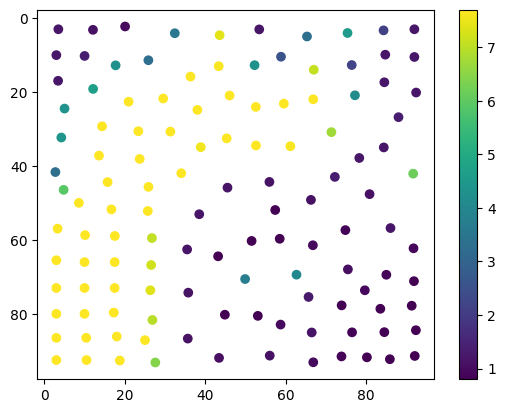

In [23]:
#plot the centorids and colour them by their values
plt.scatter(data.centroid[:, 1], data.centroid[:, 0], c=values, cmap="viridis")
#flip y axis
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
#rotate the plot by 90 degrees
#rotate the plot by 90 degrees
plt.colorbar()

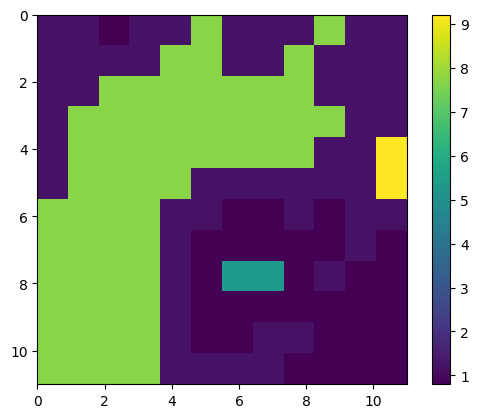

In [24]:
#plot the weights and add a colorbar
plt.imshow(weights, extent=([0, 11, 11,0]),)
plt.colorbar()

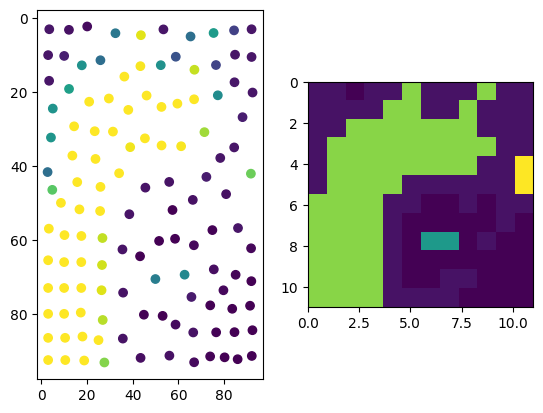

In [25]:
#plot them side by side
fig, axs = plt.subplots(1,2)
axs[0].scatter(data.centroid[:, 1], data.centroid[:, 0], c=values, cmap="viridis")
axs[0].invert_yaxis()
axs[1].imshow(weights, extent=([0, 11, 11,0]),)


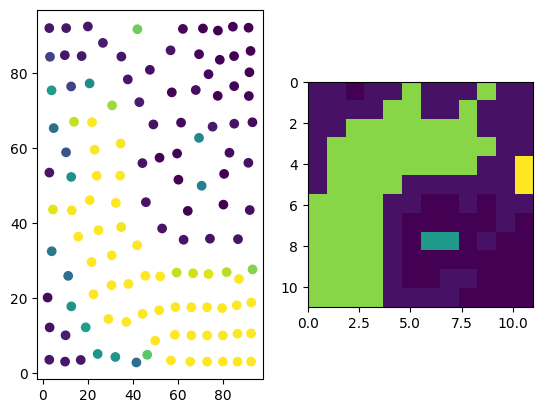

In [26]:
#plot them side by side
fig, axs = plt.subplots(1,2)
axs[0].scatter(data.centroid[:, 0], data.centroid[:, 1], c=values, cmap="viridis")
axs[1].imshow(weights, extent=([0, 11, 11,0]),)


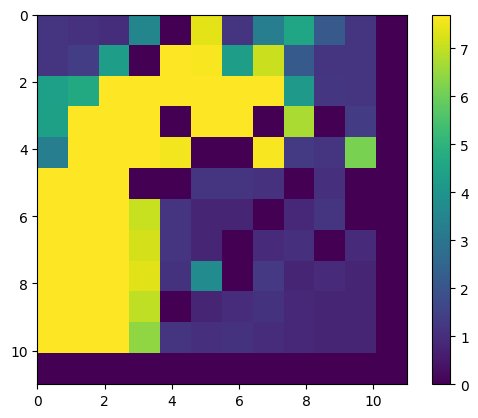

In [36]:
#create an image using the scatter plot where ach of the centroids is a pixel
#with the value of the centroid value
#first create an empty image
new_image = np.zeros((12, 12))
#now fill the image with the values
new_image[centroid[:, 0].astype(int), centroid[:, 1].astype(int)] = values
#plot the image
plt.imshow(new_image, extent=([0, 11, 11,0]),cmap="viridis")
plt.colorbar()